# <center>  Principal Component Analysis and Boosting - 04/11/2020 </center>#

* <span style="color:red">Cours</span>            : MICAS911-Introduction-To-Statistical-Learning
* <span style="color:red">Auteur</span>           : Bounhar Abdelaziz
* <span style="color:red">Auteur</span>           : Yu Yeh
* <span style="color:red">Auteur</span>           : Panongbene Jean Mohamed Sawadogo

# <center> <span style="color:red"><font size="+3"> Assignment Principal Component Analysis and Boosting  </font></span> </center> #

# Exercice 2

AdaBoost algorithm for a two-class classification problem. The algorithm sequentially applies a weak classification to modified versions of the data. By increasing the weights of the missclassified observations, each weak learner focuses on the error of the previous one. The predictions are aggregated through a weighted majority vote.

In [140]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_hastie_10_2
import matplotlib.pyplot as plt
from tqdm import tqdm

In [141]:
# Useful starting lines
%matplotlib inline

%load_ext autoreload
%autoreload 2

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# TO-DO : Adaboost

## Helpers Functions

In [142]:
def plot_error_rate(er_train, er_test):
    df_error = pd.DataFrame([er_train, er_test]).T
    df_error.columns = ['Training', 'Test']
    plot1 = df_error.plot(linewidth = 3, figsize = (8,6),
            color = ['lightblue', 'darkblue'], grid = True)
    plot1.set_xlabel('Number of iterations', fontsize = 12)
    plot1.set_xticklabels(range(0,450,50))
    plot1.set_ylabel('Error rate', fontsize = 12)
    plot1.set_title('Error rate vs number of iterations', fontsize = 16)
    plt.axhline(y=er_test[0], linewidth=1, color = 'red', ls = 'dashed')
    plt.savefig('adaboost.pdf',format='pdf')

In [143]:
def get_error_rate(pred, Y):
    return sum(pred != Y) / float(len(Y))

In [144]:
def print_error_rate(err):
    print('Error rate: Training: %.4f - Test: %.4f'.format(err))

## Weak Learners

In [145]:
def generic_clf(Y_train, X_train, Y_test, X_test, clf):
    clf.fit(X_train,Y_train)
    pred_train = clf.predict(X_train)
    pred_test = clf.predict(X_test)
    return get_error_rate(pred_train, Y_train),get_error_rate(pred_test, Y_test)

# Datasets :
##### Generates data for binary classification used in Hastie et al. 2009, Example 10.2.

In [231]:
# Read data
x, y = make_hastie_10_2()
df = pd.DataFrame(x)
df['Y'] = y

# Split into training and test set
train, test = train_test_split(df, test_size = 0.2)
X_train, Y_train = train.iloc[:,:-1], train.iloc[:,-1]
X_test, Y_test = test.iloc[:,:-1], test.iloc[:,-1]

In [232]:
# Fit a simple decision tree first
clf_tree = DecisionTreeClassifier(max_depth = 1, random_state = 1)
er_tree = generic_clf(Y_train, X_train, Y_test, X_test, clf_tree)
print('Single Weak Learner Achieves \n Train Error of {} \n Test Error of {}'.format(er_tree[0],er_tree[1]))

Single Weak Learner Achieves 
 Train Error of 0.46291666666666664 
 Test Error of 0.46791666666666665


# Implement an adaboost classifier

In [233]:
p1 = np.array([1,0,1,1,1,0,0])
p2 = np.array([0,1,0,1,1,0,1])

x = np.sum(p1 != p2)
x

In [278]:
def adaboost_clf(Y_train, X_train, Y_test, X_test, M, clf):
    n_train, n_test = len(X_train), len(X_test)
    # Initialize weights
    w = np.ones(n_train) / n_train # uniform distribution over the weights
    pred_train, pred_test = [np.zeros(n_train), np.zeros(n_test)]
    
    for i in range(M):
        # Fit a classifier with the specific weights
        clf.fit(X_train, Y_train, sample_weight = w)
        pred_train_i = clf.predict(X_train)
        pred_test_i = clf.predict(X_test)
        
        y = Y_train.to_numpy()

        # Indicator function
        miss = np.sum(pred_test_i != Y_test)
        err_m = 0
        
        # Error
        for j in range(len(pred_train_i)):
            missed = 0
            if pred_train_i[j] != y[j] :
                missed = 1 
            err_m = err_m + w[j]*missed
        err_m = err_m/np.sum(w)
        
        
        # Equivalent with 1/-1 to update weights
        miss2 = 0
        
        # Alpha
        if np.absolute(np.log((1-err_m)/err_m)) < np.finfo(float).eps :
            alpha_m = np.finfo(float).eps
        else :
            alpha_m = np.log((1-err_m)/err_m)
            
        # New weights
        for j in range(len(w)):
            missed = 0
            if pred_train_i[j] != y[j] :
                missed = 1 
            w[j] = w[j]*np.exp(alpha_m*missed)
        
        # Add to prediction
        pred_train = [sum(x) for x in zip(pred_train, 
                                          [x * alpha_m for x in pred_train_i])]
        pred_test = [sum(x) for x in zip(pred_test, 
                                         [x * alpha_m for x in pred_test_i])]
    
    pred_train, pred_test = np.sign(pred_train), np.sign(pred_test)
    # Return error rate in train and test set
    #print(w)
    return get_error_rate(pred_train, Y_train), get_error_rate(pred_test, Y_test)

# Fit Adaboost classifier using a decision tree as base estimator

In [293]:
# let's see if the data is scaled
X_train.describe()

,0,1,2,3,4,5,6,7,8,9
count,9600.000000,9600.000000,9600.000000,9600.000000,9600.000000,9600.000000,9600.000000,9600.000000,9600.000000,9600.000000
mean,0.004301,-0.002104,0.014658,0.012982,-0.001392,-0.002157,-0.005292,0.003780,0.006280,0.013691
std,1.009721,0.995601,1.007999,1.002758,0.997878,1.002542,1.005970,1.006299,1.003357,1.004431
min,-4.231660,-3.964739,-3.803163,-3.793160,-3.405549,-4.126234,-3.840847,-4.157044,-4.130087,-3.866375
25%,-0.687540,-0.663764,-0.667213,-0.662356,-0.673883,-0.684058,-0.686775,-0.674303,-0.658946,-0.657534
50%,0.014101,-0.000042,0.022523,0.014025,-0.005444,-0.008149,-0.011431,-0.005526,-0.001126,0.011206
75%,0.686070,0.680188,0.696581,0.701613,0.667247,0.669876,0.676194,0.695969,0.679555,0.689611
max,3.695534,4.126305,4.038874,4.052596,3.773010,4.230645,3.895823,3.464935,3.872593,3.468881




  0%|                                                                                           | 0/39 [00:00<?, ?it/s]

  3%|██▏                                                                                | 1/39 [00:00<00:24,  1.54it/s]

  5%|████▎                                                                              | 2/39 [00:01<00:31,  1.18it/s]

  8%|██████▍                                                                            | 3/39 [00:03<00:41,  1.16s/it]

 10%|████████▌                                                                          | 4/39 [00:06<00:55,  1.58s/it]

 13%|██████████▋                                                                        | 5/39 [00:09<01:09,  2.04s/it]

 15%|████████████▊                                                                      | 6/39 [00:13<01:25,  2.60s/it]

 18%|██████████████▉                                                                    | 7/39 [00:17<01:39,  3.10s/it]

 21%|█████████████████        

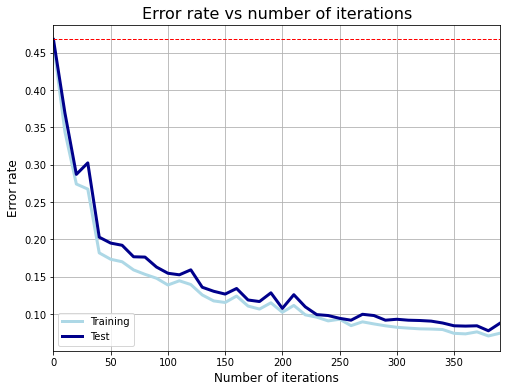

In [279]:
# Test with different number of iterations
er_train, er_test = [er_tree[0]], [er_tree[1]]
x_range = range(10, 400, 10)

for i in tqdm(x_range):
    er_i = adaboost_clf(Y_train, X_train, Y_test, X_test, i, clf_tree)
    er_train.append(er_i[0])
    er_test.append(er_i[1])
    
# Compare error rate vs number of iterations
plot_error_rate(er_train, er_test)

### Comments :

We can clearly see that over the iterations of the training phase, the classifier gets betters and better, untill it reaches a level of error rate =0.1 and stops from improving a lot. Actually, if we increase the number of iterations, after reaching a certain number of iteration, the classifier will be overfitting the training data. 
This treshold is caracterized by : nbrOfIteration >> VCdim(H).

In the next experience, we will try to find this maximum number of Iteration for which we will be overfitting the training data.




  0%|                                                                                           | 0/79 [00:00<?, ?it/s]


  1%|█                                                                                  | 1/79 [00:00<00:44,  1.76it/s]


  3%|██                                                                                 | 2/79 [00:01<01:02,  1.24it/s]


  4%|███▏                                                                               | 3/79 [00:04<01:31,  1.21s/it]


  5%|████▏                                                                              | 4/79 [00:07<02:15,  1.80s/it]


  6%|█████▎                                                                             | 5/79 [00:12<03:23,  2.75s/it]


  8%|██████▎                                                                            | 6/79 [00:20<05:21,  4.40s/it]


  9%|███████▎                                                                           | 7/79 [00:25<05:27,  4.55s/it]


 10%|████████▍       

 85%|█████████████████████████████████████████████████████████████████████▌            | 67/79 [23:28<07:37, 38.11s/it]


 86%|██████████████████████████████████████████████████████████████████████▌           | 68/79 [24:08<07:06, 38.74s/it]


 87%|███████████████████████████████████████████████████████████████████████▌          | 69/79 [24:52<06:41, 40.20s/it]


 89%|████████████████████████████████████████████████████████████████████████▋         | 70/79 [25:37<06:15, 41.72s/it]


 90%|█████████████████████████████████████████████████████████████████████████▋        | 71/79 [26:23<05:43, 42.89s/it]


 91%|██████████████████████████████████████████████████████████████████████████▋       | 72/79 [27:10<05:09, 44.24s/it]


 92%|███████████████████████████████████████████████████████████████████████████▊      | 73/79 [28:00<04:36, 46.10s/it]


 94%|████████████████████████████████████████████████████████████████████████████▊     | 74/79 [28:56<04:04, 48.92s/it]


 95%|███████████████████

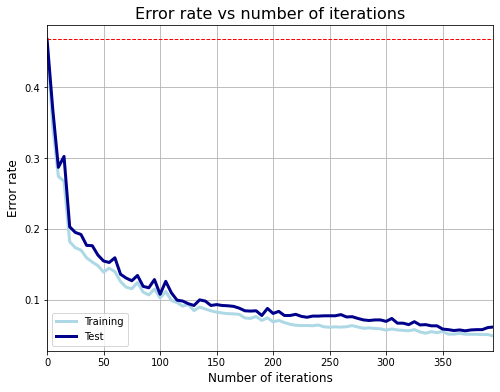

In [291]:
# Test with different number of iterations
er_train, er_test = [er_tree[0]], [er_tree[1]]
x_range = range(10, 800, 10)

for i in tqdm(x_range):
    er_i = adaboost_clf(Y_train, X_train, Y_test, X_test, i, clf_tree)
    er_train.append(er_i[0])
    er_test.append(er_i[1])
    
# Compare error rate vs number of iterations
plot_error_rate(er_train, er_test)

In [294]:
# Test with different number of iterations
er_train, er_test = [er_tree[0]], [er_tree[1]]
x_range = range(10, 1300, 10)

for i in tqdm(x_range):
    er_i = adaboost_clf(Y_train, X_train, Y_test, X_test, i, clf_tree)
    er_train.append(er_i[0])
    er_test.append(er_i[1])
    
# Compare error rate vs number of iterations
plot_error_rate(er_train, er_test)




  0%|                                                                                          | 0/129 [00:00<?, ?it/s]


  1%|▋                                                                                 | 1/129 [00:00<01:22,  1.55it/s]


  2%|█▎                                                                                | 2/129 [00:01<01:48,  1.17it/s]


  2%|█▉                                                                                | 3/129 [00:03<02:30,  1.19s/it]


  3%|██▌                                                                               | 4/129 [00:06<03:19,  1.60s/it]

KeyboardInterrupt: 



  0%|                                                                                           | 0/39 [00:00<?, ?it/s]

[0.0002465  0.00022215 0.00022215 ... 0.00022215 0.00019147 0.00022215]




  3%|██▏                                                                                | 1/39 [00:00<00:24,  1.56it/s]

[0.00052061 0.00055462 0.00044885 ... 0.00039907 0.00039968 0.00044885]




  5%|████▎                                                                              | 2/39 [00:01<00:30,  1.22it/s]

[0.0012816  0.00135754 0.00094335 ... 0.00080224 0.00097829 0.00109865]




  8%|██████▍                                                                            | 3/39 [00:03<00:43,  1.19s/it]

[0.00248493 0.00287617 0.00199864 ... 0.00169968 0.0017665  0.00232769]




 10%|████████▌                                                                          | 4/39 [00:06<00:57,  1.66s/it]

[0.00535665 0.0051191  0.00415927 ... 0.00304296 0.00367617 0.00484403]




 13%|██████████▋                                                                        | 5/39 [00:09<01:13,  2.15s/it]

[0.01005156 0.01074055 0.00737637 ... 0.00638454 0.00771309 0.01016341]




 15%|████████████▊                                                                      | 6/39 [00:13<01:26,  2.62s/it]

[0.0217951  0.01980474 0.01643211 ... 0.01048368 0.01718222 0.02000422]




 18%|██████████████▉                                                                    | 7/39 [00:18<01:44,  3.26s/it]

[0.04413343 0.03885718 0.03224004 ... 0.02056912 0.02954155 0.03465309]




 21%|█████████████████                                                                  | 8/39 [00:23<01:55,  3.74s/it]

[0.07678924 0.08284132 0.06873395 ... 0.03826238 0.06298094 0.07387845]




 23%|███████████████████▏                                                               | 9/39 [00:28<02:07,  4.25s/it]

[0.13120932 0.15242556 0.12646842 ... 0.05303152 0.11588304 0.13593414]




 26%|█████████████████████                                                             | 10/39 [00:34<02:19,  4.81s/it]

[0.21265134 0.26773952 0.22126074 ... 0.10344794 0.22605163 0.26516507]




 28%|███████████████████████▏                                                          | 11/39 [00:41<02:32,  5.45s/it]

[0.46854792 0.45603576 0.44682997 ... 0.20891026 0.34287642 0.47741327]




 31%|█████████████████████████▏                                                        | 12/39 [00:49<02:41,  5.99s/it]

[0.88212231 0.89910393 0.88095412 ... 0.36617238 0.67600298 0.94125107]




 33%|███████████████████████████▎                                                      | 13/39 [00:56<02:50,  6.56s/it]

[1.74074815 1.48085578 1.45096241 ... 0.60309879 1.11340068 1.55027361]




 36%|█████████████████████████████▍                                                    | 14/39 [01:05<02:59,  7.17s/it]

[2.80065777 2.5245404  1.89025113 ... 1.02815363 1.89810852 2.27016071]




 38%|███████████████████████████████▌                                                  | 15/39 [01:15<03:09,  7.88s/it]

[3.98308107 4.32719578 3.23999043 ... 1.76230971 3.25345842 3.89117554]




 41%|█████████████████████████████████▋                                                | 16/39 [01:25<03:20,  8.70s/it]

[6.95327137 6.96705918 4.6802167  ... 2.55099651 5.23827404 6.26503899]




 44%|███████████████████████████████████▋                                              | 17/39 [01:36<03:21,  9.18s/it]

[10.1851345  10.44473382  7.01639191 ...  3.82435096  7.85300894
  9.39229349]




 46%|█████████████████████████████████████▊                                            | 18/39 [01:48<03:33, 10.16s/it]

[15.9340043  20.78246757 11.98097094 ...  7.60952373 14.21193991
 18.68836854]




 49%|███████████████████████████████████████▉                                          | 19/39 [02:00<03:34, 10.73s/it]

[29.11915124 28.72962746 18.58237858 ... 11.80230313 19.64654763
 28.98549217]




 51%|██████████████████████████████████████████                                        | 20/39 [02:13<03:34, 11.31s/it]

[43.33160807 51.31724894 38.63783627 ... 21.08143339 40.85053414
 60.26874846]




 54%|████████████████████████████████████████████▏                                     | 21/39 [02:27<03:37, 12.08s/it]

[95.66730132 90.60352501 68.21729998 ... 37.22047103 72.12394405
 82.09055439]




 56%|██████████████████████████████████████████████▎                                   | 22/39 [02:40<03:34, 12.59s/it]

[145.99869166 167.36913263 126.01574085 ...  56.413957   121.4113489
 151.64338126]




 59%|████████████████████████████████████████████████▎                                 | 23/39 [02:55<03:30, 13.16s/it]

[227.08152405 248.21033014 186.88277908 ...  83.66254083 180.05441337
 207.39006178]




 62%|██████████████████████████████████████████████████▍                               | 24/39 [03:10<03:26, 13.79s/it]

[397.0846334  469.15680454 270.45150319 ... 130.6568958  340.33133582
 339.21070777]




 64%|████████████████████████████████████████████████████▌                             | 25/39 [03:29<03:33, 15.27s/it]

[659.46448695 696.88427296 461.46915143 ... 222.93877505 580.70452888
 503.86268552]




 67%|██████████████████████████████████████████████████████▋                           | 26/39 [03:46<03:25, 15.79s/it]

[1050.24757075 1364.21140134  793.16081319 ...  436.42198644  843.83086092
  866.02568374]




 69%|████████████████████████████████████████████████████████▊                         | 27/39 [04:05<03:22, 16.89s/it]

[1527.6452834  2006.26573937 1166.45511374 ...  641.82023288 1240.97258271
 1273.6132076 ]




 72%|██████████████████████████████████████████████████████████▊                       | 28/39 [04:23<03:08, 17.13s/it]

[2292.18203361 2898.7789478  1547.36744639 ...  927.34224725 1793.03525299
 1840.19648115]




 74%|████████████████████████████████████████████████████████████▉                     | 29/39 [04:41<02:55, 17.50s/it]

[3177.33624393 4085.86675572 2181.03460868 ... 1307.10099923 2527.30658804
 2593.78095457]




 77%|███████████████████████████████████████████████████████████████                   | 30/39 [05:00<02:41, 17.94s/it]

[4278.26391198 5571.56096776 2974.09779163 ... 1782.38629492 3446.28045439
 3337.90302986]




 79%|█████████████████████████████████████████████████████████████████▏                | 31/39 [05:20<02:27, 18.44s/it]

[5817.93450288 7690.75008858 4105.32039167 ... 2460.33160811 4757.10162075
 4607.50194983]




 82%|███████████████████████████████████████████████████████████████████▎              | 32/39 [05:39<02:11, 18.72s/it]

[ 7842.00594499 11791.50699794  5611.96835162 ...  3772.19608493
  7293.61849038  7064.25132252]




 85%|█████████████████████████████████████████████████████████████████████▍            | 33/39 [05:59<01:54, 19.01s/it]

[12528.77884669 21892.27923516 11614.30669314 ...  6739.1478034
 13541.43559886 13675.45869714]




 87%|███████████████████████████████████████████████████████████████████████▍          | 34/39 [06:20<01:37, 19.48s/it]

[19996.17941124 32102.39512698 17030.98423806 ...  9882.14992509
 19856.88705647 20053.41581489]




 90%|█████████████████████████████████████████████████████████████████████████▌        | 35/39 [06:41<01:19, 19.95s/it]

[27066.25707214 46738.35852634 24795.66537719 ... 13510.54082133
 28909.93967246 29196.06883931]




 92%|███████████████████████████████████████████████████████████████████████████▋      | 36/39 [07:04<01:03, 21.13s/it]

[37598.15894775 62128.08660693 34978.26282741 ... 19058.78469484
 40782.10658215 38930.93262602]




 95%|█████████████████████████████████████████████████████████████████████████████▊    | 37/39 [07:27<00:42, 21.45s/it]

[56666.03536998 86707.70700215 48816.64848094 ... 26598.97655616
 56916.65624323 54333.10574676]




 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [07:51<00:22, 22.26s/it]

[ 81090.51649219 123684.40724312  73654.78891745 ...  42944.88305315
  76240.38313837  81791.18898573]




100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [08:17<00:00, 12.77s/it]
c:\python36\lib\site-packages\ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys


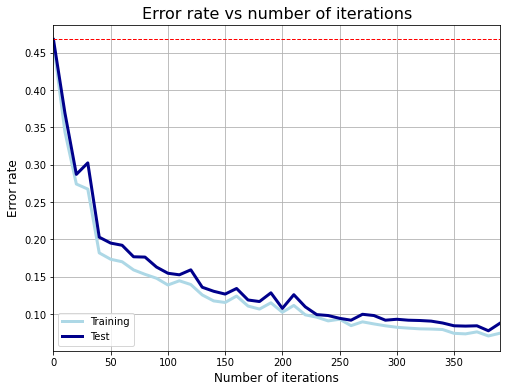

In [277]:
# Test with different number of iterations
er_train, er_test = [er_tree[0]], [er_tree[1]]
x_range = range(10, 400, 10)

for i in tqdm(x_range):
    er_i = adaboost_clf(Y_train, X_train, Y_test, X_test, i, clf_tree)
    er_train.append(er_i[0])
    er_test.append(er_i[1])
    
# Compare error rate vs number of iterations
plot_error_rate(er_train, er_test)

# PCA for dimensionality reduction and image denoising

In [5]:
from keras.datasets import mnist

Using TensorFlow backend.


In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [8]:
x_train.shape

(60000, 28, 28)

In [9]:
len(x_train)

60000

In [10]:
x_train = x_train.reshape(len(x_train), -1)/255
x_test = x_test.reshape(len(x_test), -1)/255

In [11]:
x_train.shape

(60000, 784)

## Question 1. 

Compute the eigendecomposition of the sample covariance matrix and use the eigenvalues to calculate the percentage of variance explained (given by the eigenvalues).
Plot the cumulative sum of these percentages versus the number of components.

In [12]:
all_col_mean = np.mean(x_train,0) # np.mean(x,i) -> i : 0 for columns -- 1 for for rows
x_bar = x_train - all_col_mean

In [13]:
#np.mean(x_bar,0) #The mean of each feature becomes close to zero.

In [14]:
cov_x = np.cov(x_bar.T) # check what would happen if we do the eigendecomp using X.t*X rather than using cov matrix (there should be a scalar diff)

# the scalar is (1/N-1) https://en.wikipedia.org/wiki/Sample_mean_and_covariance

In [15]:
cov_x.shape

(784, 784)

In [16]:
w, P = np.linalg.eigh(cov_x)

In [17]:
#w

In [18]:
d= 169
print(np.sum(w[:d]))
w = -np.sort(-w)
print(np.sum(w[:d]))

0.0014637421981606215
50.4245130074737


In [19]:
#P[:1 , :169].real

In [20]:
print(w.shape)

(784,)


In [21]:
print(P.shape)

(784, 784)


In [22]:
w = -np.sort(-w)
w_kept = w[:d]
P_kept = np.diag(w_kept)

In [23]:
#w_kept.real

In [24]:
P_kept = P[:500 , :500]

In [25]:
print(P_kept.shape)

(500, 500)


In [26]:
np.sum(P) - np.sum(P_kept)

-6.10079439821295

In [27]:
percentage_eigen_value = [w[i]/np.sum(w) for i in range(len(w)) ]
sum(percentage_eigen_value)

0.9999999999999994

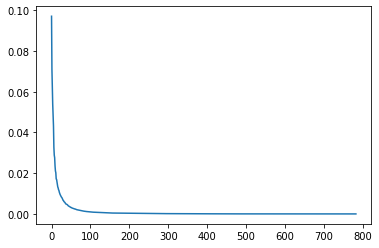

In [28]:
plt.plot(percentage_eigen_value)

In [29]:
my_cumulative_percentage_eigen_value = [np.sum(percentage_eigen_value[:i]) for i in range(len(w))]

In [30]:
cumulative_percentage_eigen_value = np.cumsum(percentage_eigen_value)

In [31]:
#cumulative_percentage_eigen_value

In [32]:
np.allclose(cumulative_percentage_eigen_value, my_cumulative_percentage_eigen_value,  rtol=1e-05)

False

In [33]:
err_precision = 0
for i in range(len(cumulative_percentage_eigen_value)):
    err_i = cumulative_percentage_eigen_value[i] - my_cumulative_percentage_eigen_value[i]
    err_precision = err_precision + err_i
print("err_precision = ",err_precision)

err_precision =  0.9999999999996942


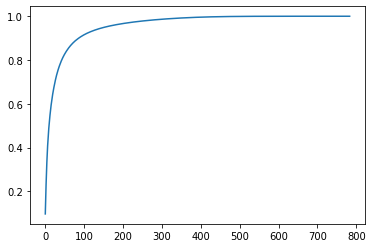

In [34]:
plt.plot(cumulative_percentage_eigen_value)

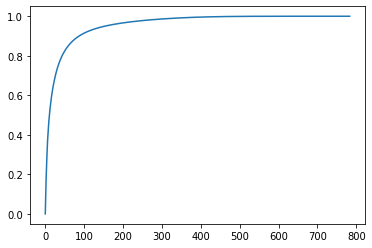

In [35]:
plt.plot(my_cumulative_percentage_eigen_value)

### Comments :

We can clearly see that more than 90% of the data is contained in the first 100 components. Which means that 100 components are sufficient to describe 90% of the data. We also observe that after, there's a certain monotonity, that is the other components doesn't add much informations.
This actually was predictible since in our images the real information (the number) is concentrated in few pixels.

We will build a function down bellow that will give us the exact number of dimensions to keep in order to keep a percentage of the original data.

In [36]:
def findNumberOfDimensionByDesiredCumulativePercentage(cumulative_percentage_eigen_value, desiredCumulativePercentage):
    """ 
    This function helps us find the number of principale components (dimensions) by keeping only the desired percentage
    of informations from the original data.
    """
    
    for i in range(len(cumulative_percentage_eigen_value)):
        if cumulative_percentage_eigen_value[i] >= desiredCumulativePercentage :
            return i

In [37]:
desiredCumulativePercentage = 0.90
findNumberOfDimensionByDesiredCumulativePercentage(cumulative_percentage_eigen_value, desiredCumulativePercentage)

86

* For example to keep 90% of informations of the data we can keep only 86 dimensions, which can be confirmerd from the figure above.

## Question 2
## PCA Algorithm

In [38]:
def PCA(X, forcedNbrDim, desiredCumulativePercentage=0.85, plot=False):
    
    all_col_mean = np.mean(X,0) # np.mean(x,i) -> i : 0 for columns -- 1 for for rows
    # we construct the X bar
    x_bar = X - all_col_mean 
    # covariance matrix
    cov_x = np.cov(x_bar.T)     
    # SVD
    w, P = np.linalg.eig(cov_x)
    
    percentage_eigen_value = [w[i]/np.sum(w) for i in range(len(w)) ]
    print("Sum of percentage_eigen_value : ", sum(percentage_eigen_value))
    cumulative_percentage_eigen_value = np.cumsum(percentage_eigen_value)
    
    if plot :
        plt.plot(cumulative_percentage_eigen_value)
    
    # number of dimensions to keep 
    if forcedNbrDim < 0: # we set a negative forcedDim if we want to use the computation from the cumulative percentage
        d = findNumberOfDimensionByDesiredCumulativePercentage(cumulative_percentage_eigen_value, desiredCumulativePercentage)
    else :
        d = forcedNbrDim
    
    # we keep only the d first eigein values of P
    
    P_kept = P[: , :d]
    print("P_kept : ",P_kept.shape)
    print("Dimensions to keep : ",d)
    #w_kept = w[:d] 
    #P_kept = np.diag(w_kept)
    #Y = np.dot(x_bar, P_kept.real)
    
    Y = np.dot(x_bar, P_kept)
    Xhat = np.dot(Y, P_kept.T) + all_col_mean
    
    # Errors computations
    X_fnom = np.linalg.norm(X, 'fro')
    M = X - Xhat
    M_fnorm = np.linalg.norm(M, 'fro')
    reconstructionError = M_fnorm/X_fnom
    print("Normalized reconstruction error : ",reconstructionError)
    return Xhat, Y, d, reconstructionError

In [39]:
desiredCumulativePercentage=0.85
forcedNbrDim = -1
Xhat, Y, d, reconstructionError = PCA(x_train, forcedNbrDim, desiredCumulativePercentage)

Sum of percentage_eigen_value :  (0.9999999999999998+0j)
P_kept :  (784, 58)
Dimensions to keep :  58
Normalized reconstruction error :  0.3024527547774581


In [40]:
print(x_train.shape)
print(Xhat.shape)
print(Y.shape)

(60000, 784)
(60000, 784)
(60000, 58)


In [41]:
Xhat[0].reshape(28,-1).shape

(28, 28)

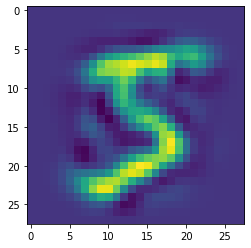

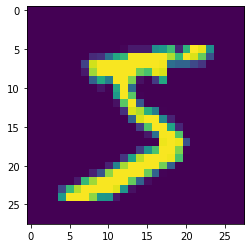

In [42]:
i = 0
y = Xhat[i].real.reshape(28,28)
plt.imshow(y)
plt.show()
y = x_train[i].real.reshape(28,28)
plt.imshow(y)

----------- p =  50 -------------
Sum of percentage_eigen_value :  (0.9999999999999998+0j)
P_kept :  (784, 50)
Dimensions to keep :  50
Normalized reconstruction error :  0.3244839105237107


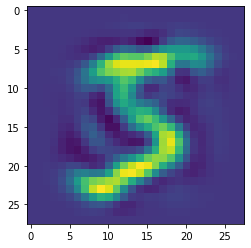

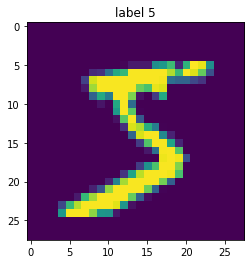



----------- p =  250 -------------
Sum of percentage_eigen_value :  (0.9999999999999998+0j)
P_kept :  (784, 250)
Dimensions to keep :  250
Normalized reconstruction error :  0.11476437541142882


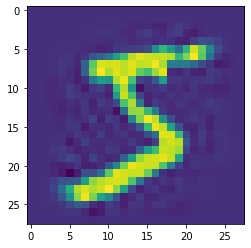

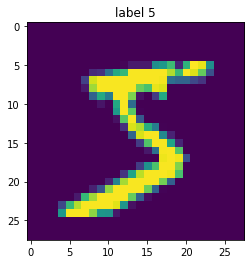



----------- p =  500 -------------
Sum of percentage_eigen_value :  (0.9999999999999998+0j)
P_kept :  (784, 500)
Dimensions to keep :  500
Normalized reconstruction error :  0.02121724407664908


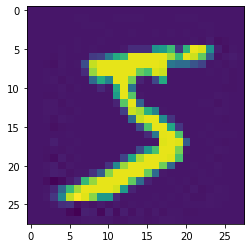

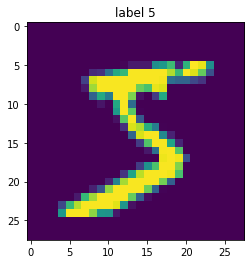



[0.3244839105237107, 0.11476437541142882, 0.02121724407664908]


In [43]:
dimensions = [50, 250, 500]
reconstructionErrors = []
for p in dimensions :
    print("----------- p = ",p,"-------------")
    Xhat, Y, d, reconstructionError = PCA(x_train, p, desiredCumulativePercentage)
    reconstructionErrors.append(reconstructionError)
    
    i = 0
    xhat_im = Xhat[i].real.reshape(28,28)
    plt.imshow(xhat_im)
    plt.show()
    x_im = x_train[i].real.reshape(28,28)
    plt.imshow(x_im)
    plt.title('label %d'%(y_train[i]))
    plt.show()
    print("\n")
    
print(reconstructionErrors)

## Playing with the images


## Question 3
### Adding Noise to image data

In [281]:
def generateNoise(data, sigma2, mean=0):
    
    #cov_matrix = sigma2*np.diag([1,1])
    #bruit = sigma2*np.random.multivariate_normal(mean, cov_matrix, data.shape[0])
    
    bruit = np.random.normal(mean, sigma2, data.shape)       #(data.shape[0], data.shape[1])      
    
    # we add the noise
    data_bruite = data + bruit
    
    # Rescalling the pixels new values to [0,255]  to avoid having pixels with values greater than 255 or less than 0.
    #data_bruite[ data_bruite > 255 ] = 255 
    #data_bruite[ data_bruite < 0 ] = 0
    data_bruite = np.clip(data_bruite, 0, 1)
    #reshaping the data
    data_bruite[0].reshape(28,28).shape
    
    return data_bruite
    
def plotImageData(nbrImageToPlot, data, label):
    
    for k in range(nbrImageToPlot):
        plt.imshow(data[k].reshape(28,28))
        plt.title('label %d'%(label[k]))
        plt.show()

def addNoiseToData(data, label, sigma2, nbrImageToPlot, mean=0) :
    
    data_bruite = generateNoise(data, sigma2, mean)
    plotImageData(nbrImageToPlot, data_bruite, label)
    
    return data_bruite

In [282]:
x_train[0].reshape(28,28).shape

(28, 28)

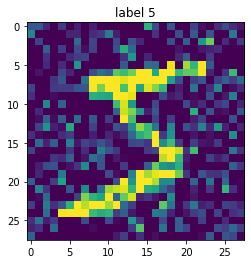

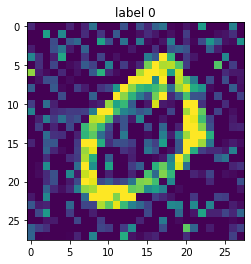

min :  0.0
max :  1.0


In [283]:
sigma2 = 0.25
mean = 0
nbrImageToPlot = 2
data_bruite = addNoiseToData(x_train, y_train, sigma2, nbrImageToPlot, mean)
print("min : ",np.min(data_bruite))
print("max : ",np.max(data_bruite))

Sum of percentage_eigen_value :  1.0000000000000018
P_kept :  (784, 534)
Dimensions to keep :  534
Normalized reconstruction error :  0.23137851261503056


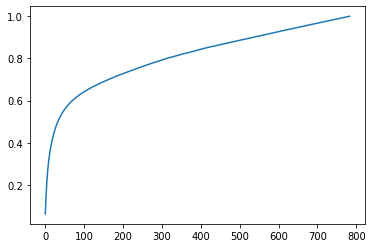

In [285]:
desiredCumulativePercentage=0.9
forcedNbrDim = -1
Xhat, Y, d, reconstructionError = PCA(data_bruite, forcedNbrDim, desiredCumulativePercentage, plot=True)

### Comments : 

In the case where we added the noise, we don't have the same curve for the cumulative explained variance versus the number of components. In fact, this is due to the fact that when there's a noise in the data, each components adds informations and thus is no more useless.

We need 534 component to describe 90% of the data, which is almost 5 times higher than the first case without noise.

To put in contrast with we had seen in the first, here the real information is hidded by the noise rather then being clear and  concentrated in few pixels.

In [286]:
desiredCumulativePercentage=0.9
forcedNbrDim = -1

Xhat_test, Y, d, reconstructionError = PCA(data_bruite, forcedNbrDim, desiredCumulativePercentage)

Sum of percentage_eigen_value :  1.0000000000000018
P_kept :  (784, 534)
Dimensions to keep :  534
Normalized reconstruction error :  0.23137851261503056


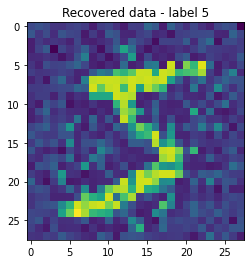

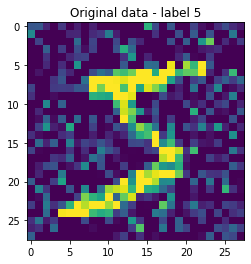

In [287]:
i = 0

xhat_im = Xhat_test[i].real.reshape(28,28)
plt.imshow(xhat_im)
plt.title('Recovered data - label %d'%(y_train[i]))
plt.show()

x_im = data_bruite[i].real.reshape(28,28)
plt.imshow(x_im)
plt.title('Original data - label %d'%(y_train[i]))
plt.show()

## Question 4

In [288]:
np.min(data_bruite)

0.0

----------- sigma2 =  0.15 -------------
Sum of percentage_eigen_value :  1.0000000000000007
P_kept :  (784, 250)
Dimensions to keep :  250
Normalized reconstruction error :  0.24568638701131926


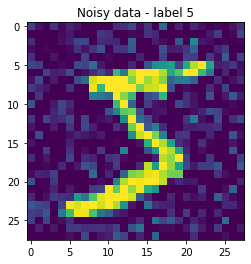

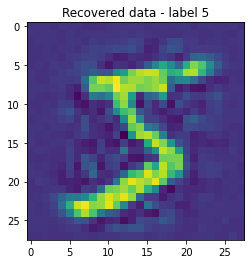



----------- sigma2 =  0.25 -------------
Sum of percentage_eigen_value :  1.0
P_kept :  (784, 250)
Dimensions to keep :  250
Normalized reconstruction error :  0.356680088603156


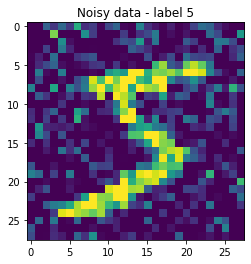

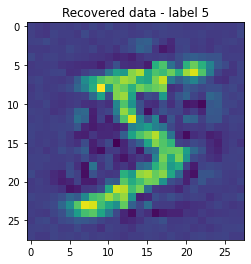



----------- sigma2 =  0.5 -------------
Sum of percentage_eigen_value :  1.0000000000000004
P_kept :  (784, 250)
Dimensions to keep :  250
Normalized reconstruction error :  0.5290028080026036


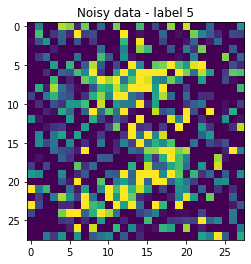

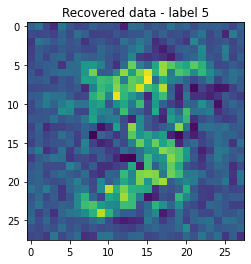



[0.24568638701131926, 0.356680088603156, 0.5290028080026036]
[250, 250, 250]


In [289]:
sigmas2 = [0.15, 0.25, 0.50]
mean = 0
reconstructionErrors = []
dimensionsToKeep = []
for sigma2 in sigmas2 :
    print("----------- sigma2 = ",sigma2,"-------------")
    data_bruite = addNoiseToData(x_train, y_train, sigma2, 0, mean)
    
    forcedNbrDim = 250
    desiredCumulativePercentage= 0.85 # not really usefull here, we already fixed forcedNbrDim to 250, use just for the PCA function params definition
    Xhat, Y, d, reconstructionError = PCA(data_bruite, forcedNbrDim, desiredCumulativePercentage)
    reconstructionErrors.append(reconstructionError)
    dimensionsToKeep.append(d)
    
    i = 0
   
    x_im = data_bruite[i].real.reshape(28,28)
    plt.imshow(x_im)
    plt.title('Noisy data - label %d'%(y_train[i]))
    plt.show()
    
    xhat_im = Xhat[i].real.reshape(28,28)
    plt.imshow(xhat_im)
    plt.title('Recovered data - label %d'%(y_train[i]))
    plt.show()
    
    print("\n")
    
print(reconstructionErrors)
print(dimensionsToKeep)

Text(0, 0.5, 'Reconstruction error')

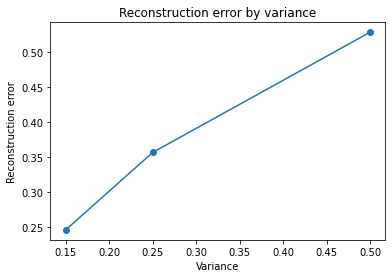

In [290]:
plt.plot(sigmas2, reconstructionErrors, '-o')
plt.title("Reconstruction error by variance")
plt.xlabel('Variance')
plt.ylabel('Reconstruction error')

### Comments : 

By fixing the number of components to keep to 250 and varying the variance, we see that the reconstruction error grows with the variance growing as shown in the Figure above.
Actually what happens is that, we are not only removing the noise component, but also part of the energy related to the input data, therefore the reconstruction error grows.

### some trash

In [82]:
N = 2000 # number of samples

# Training samples
X_train = x_train[N:]/255
y_train = y_train[:N]

# Testing samples
X_test = x_train[N:]/255
y_test = y_test[:N]

In [79]:
print("Number of lines : ",len(X_test[0]))
print("Number of columns : ",len(X_test[0][0]))

Number of lines :  28
Number of columns :  28
